<h1>Dog Breed Classification</h1>
<a id='Intro'></a>
<h1>Continued</h1>

This is a part two interactive notebook showcasing further modeling on the dog breed classification data. 
<br>
The part one notebook can be found: https://github.com/matthewjchin/dogbreedclassification/blob/main/dog_breed_class.ipynb

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# It would be recommended to run this notebook on Colab or Kaggle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(94)

In [3]:
os.getcwd()

'/kaggle/working'

In [4]:
os.chdir("/kaggle/input/dog-breed-identification")
os.getcwd()

'/kaggle/input/dog-breed-identification'

In [5]:
# The path to the files should not be like this all the time; everything done offline
# Actual project is found on Kaggle, but elected to run on own environment which best fit needs
labels = pd.read_csv("labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
train_dir = '/kaggle/input/dog-breed-identification/train'
valid_dir = '/kaggle/input/dog-breed-identification/test'

In [7]:
# Add entire folder path to image files and make it a column
labels['path'] = labels['id'].apply(lambda x : train_dir + "/"+ x + '.jpg')
labels.head()

,id,breed,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/kaggle/input/dog-breed-identification/train/0...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/kaggle/input/dog-breed-identification/train/0...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/kaggle/input/dog-breed-identification/train/0...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/kaggle/input/dog-breed-identification/train/0...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/kaggle/input/dog-breed-identification/train/0...


In [8]:
# Import TensorFlow, Keras, Scikit-learn libraries to be used

import tensorflow as tf # Use tf v2.12.0
import keras
from keras import layers, models, callbacks, optimizers
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

tf.random.set_seed(104)

2025-06-25 09:06:46.380142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750842406.601328      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750842406.670224      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Get the TensorFlow Version - we are using v2.12.0
print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [10]:
# Set up constants for model
RANDOM_STATE = 24
IMG_SIZE = 224
DOG_BREEDS = len(labels['breed'].unique())
LEARNING_RATE = 0.001
BATCH_SIZE = 32

# Epochs value may vary based on number of tests
EPOCHS = 5

In [11]:
# Check if GPU is available - only on Colab or Kaggle

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU being used for training")
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}")
else: # Use CPU
    BATCH_SIZE=16
    EPOCHS = 5
    print("Using CPU")


GPU being used for training
GPU Name: /physical_device:GPU:0
GPU Name: /physical_device:GPU:1


In [12]:
# Create a label encoding - make this the target values for y
encoder = LabelEncoder()
labels['breed_id']= encoder.fit_transform(labels['breed'])

target_vals = encoder.fit_transform(labels['breed'].values)

In [13]:
type(target_vals)

numpy.ndarray

In [14]:
print(labels.head(),
target_vals)

                                 id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                                                path  breed_id  
0  /kaggle/input/dog-breed-identification/train/0...        19  
1  /kaggle/input/dog-breed-identification/train/0...        37  
2  /kaggle/input/dog-breed-identification/train/0...        85  
3  /kaggle/input/dog-breed-identification/train/0...        15  
4  /kaggle/input/dog-breed-identification/train/0...        49   [19 37 85 ...  3 75 28]


In [15]:
# Additional preprocessing - sort out all the unique dog breeds in the train set
breeds = list(labels['breed'].value_counts().keys())
breeds = sorted(breeds, reverse=True)

In [16]:
# How many different dog breeds are in the train set?
breeds_ct = len(labels['breed'].value_counts().keys())
breeds_ct

120

In [17]:
train_dir

'/kaggle/input/dog-breed-identification/train'

In [18]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [19]:
'''Set up variables x, y to load images from train_dir into array/matrix form (seen in last cell)
Adjust size as appropriate and put everything in list form
Create dataset y of dummy variables of dog breeds and then get shapes

x - type numpy array
y - type dataframe
'''


x= np.array([img_to_array(load_img(image, target_size=(IMG_SIZE, IMG_SIZE)))
             for image in labels['path'].values.tolist()])
y = pd.get_dummies(labels['breed'])
print(type(x), type(y))

<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


In [20]:
# Do the train-test split
# Implement the training and validation sets for x, y so that train-test size is 80%-20%
 
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)

(8177, 224, 224, 3) (8177, 120)
(2045, 224, 224, 3) (2045, 120)


In [21]:
print(type(x_train), type(x_valid), type(y_train), type(y_valid))
print(x_train.dtype, x_valid.dtype)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
float32 float32


<a id='Different'></a>
## <h1>Trying a Different Model</h1>

Try another model to see if we can get better predictions.<br>
<br>

First, perform some image augmentation using ImageDataGenerator on the train data.<br>
Also, set up a data generator for validation data.<br>

We will use VGG19 as the architecture to try and get better predictions.

In [22]:
# Set up the ImageDataGenerator for train and validation data
# For validation data, don't alter images


from keras.applications import (ResNet50, ResNet101, 
                                InceptionResNetV2, InceptionV3,
                                EfficientNetB0, 
                                VGG16, VGG19)

train_data_gen = ImageDataGenerator(
    rescale=1./224., rotation_range=45,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True
)

valid_data_gen = ImageDataGenerator(rescale=1./ 224.)

In [23]:
# Generate images for train and validation sets using flow, passing x_train, y_train, and set batch_size
train_gen = train_data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [24]:
# valid_gen = valid_data_gen.flow(x_valid, y_valid, batch_size=BATCH_SIZE)

valid_gen = valid_data_gen.flow_from_directory('/kaggle/input/dog-breed-identification', target_size=(IMG_SIZE, IMG_SIZE), classes=['test'])

Found 10357 images belonging to 1 classes.


In [25]:
# Create VGG19 model base with input shape down to (224, 224, 3) and excluding top layer to be modified in later cells

img_shape = (IMG_SIZE, IMG_SIZE, 3)
model = VGG19(input_shape=img_shape, include_top=False, weights='imagenet')

for layer in model.layers:
    layer.trainable = False

I0000 00:00:1750842500.549365      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750842500.550061      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Get summary of ResNet50V2 model
model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [27]:
last_layer = model.get_layer('block5_pool')
last_layer_output = last_layer.output
last_layer_output.name

'keras_tensor_21'

In [28]:
last_layer_output.shape

(None, 7, 7, 512)

In [29]:
from keras import optimizers
from keras import layers
# Set up layers for the model, then initialize using base to compile the model

# Get layers to be one single dimension
x = layers.Flatten()(last_layer_output)

# Add a layer with 256 units and ReLU, which would make this layer fully connected
x = layers.Dense(256, activation='relu')(x)

# Normalize the batch
x = layers.BatchNormalization()(x)

# Add another layer with 256 units and ReLU, which would make this layer fully connected
x = layers.Dense(256, activation='relu')(x)

# Make a sigmoid layer with sigmoid
x = layers.Dense(1, activation='sigmoid')(x)

# Set dropout rate to 0.6
x = layers.Dropout(0.6)(x)

# Normalize the batch again
x = layers.BatchNormalization()(x)

# Initialize the output variable using dense softmax layer
output = layers.Dense(120, activation='softmax')(x)

model = models.Model(model.input, output)
# model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), 
#               loss='binary_crossentropy', metrics=['acc'])



In [30]:
# Compile the model using RMSprop

model.compile(optimizer='adam',
             loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
# Fit the model using training and validation data
history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_valid, y_valid),
                   verbose=1)

Epoch 1/10


I0000 00:00:1750842518.838056      69 service.cc:148] XLA service 0x79ba20002970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750842518.838955      69 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750842518.838986      69 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750842519.415228      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/256 ━━━━━━━━━━━━━━━━━━━━ 1:08:53 16s/step - accuracy: 0.0000e+00 - loss: 4.8018

I0000 00:00:1750842531.092242      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


256/256 ━━━━━━━━━━━━━━━━━━━━ 107s 356ms/step - accuracy: 0.0119 - loss: 4.7937 - val_accuracy: 0.0137 - val_loss: 4.7823
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 77s 301ms/step - accuracy: 0.0138 - loss: 4.7733 - val_accuracy: 0.0156 - val_loss: 4.7748
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 77s 300ms/step - accuracy: 0.0139 - loss: 4.7617 - val_accuracy: 0.0147 - val_loss: 4.7660
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 76s 298ms/step - accuracy: 0.0145 - loss: 4.7482 - val_accuracy: 0.0132 - val_loss: 4.7515
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 77s 301ms/step - accuracy: 0.0160 - loss: 4.7323 - val_accuracy: 0.0176 - val_loss: 4.7329
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 77s 301ms/step - accuracy: 0.0140 - loss: 4.7203 - val_accuracy: 0.0156 - val_loss: 4.7296
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 77s 301ms/step - accuracy: 0.0149 - loss: 4.7043 - val_accuracy: 0.0142 - val_loss: 4.7045
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 76s 299ms/step - accuracy: 0.0147 - loss: 4.7017 - va

In [32]:
# Run predictions on the model using the test generator
y_pred = model.predict(valid_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 97s 296ms/step


In [33]:
y_pred

array([[0.00862773, 0.01282286, 0.00980656, ..., 0.00956163, 0.00960161,
        0.00917856],
       [0.00863599, 0.01285047, 0.00981824, ..., 0.0095653 , 0.00961654,
        0.00919195],
       [0.00864725, 0.01288826, 0.00983419, ..., 0.0095703 , 0.00963694,
        0.00921025],
       ...,
       [0.00863686, 0.0128534 , 0.00981948, ..., 0.00956569, 0.00961812,
        0.00919337],
       [0.00863772, 0.01285627, 0.00982069, ..., 0.00956607, 0.00961967,
        0.00919476],
       [0.00863822, 0.01285794, 0.0098214 , ..., 0.00956629, 0.00962057,
        0.00919557]], dtype=float32)

In [34]:
type(valid_data_gen)

keras.src.legacy.preprocessing.image.ImageDataGenerator

In [35]:
# valid_gen = valid_data_gen.flow_from_directory('/kaggle/input/dog-breed-identification', target_size=(IMG_SIZE, IMG_SIZE), classes=['test'])
preds = model.predict(valid_gen)

324/324 ━━━━━━━━━━━━━━━━━━━━ 76s 234ms/step


In [36]:
preds

array([[0.00863773, 0.01285631, 0.00982071, ..., 0.00956608, 0.0096197 ,
        0.00919478],
       [0.00862602, 0.01281715, 0.00980414, ..., 0.00956086, 0.00959853,
        0.00917579],
       [0.00863525, 0.01284799, 0.00981719, ..., 0.00956498, 0.0096152 ,
        0.00919075],
       ...,
       [0.00861654, 0.01278556, 0.00979074, ..., 0.00955661, 0.00958143,
        0.00916045],
       [0.00862976, 0.01282964, 0.00980943, ..., 0.00956253, 0.00960528,
        0.00918185],
       [0.00864314, 0.01287446, 0.00982837, ..., 0.00956848, 0.00962949,
        0.00920357]], dtype=float32)

In [37]:
import re

# Get all filenames and put them into the list for the submission file
file_list = valid_gen.filenames
id_list = []
for name in file_list:
    m = re.sub('test/', '', name)
    m = re.sub('.jpg', '', m)
    id_list.append(m)


In [38]:
history.history

{'accuracy': [0.012229423969984055,
  0.014797602780163288,
  0.015775956213474274,
  0.01602054573595524,
  0.016754310578107834,
  0.01687660440802574,
  0.016632016748189926,
  0.01687660440802574,
  0.0169989001005888,
  0.017243487760424614],
 'loss': [4.7889404296875,
  4.774616718292236,
  4.761275768280029,
  4.747971057891846,
  4.732914447784424,
  4.719395160675049,
  4.710752964019775,
  4.69787073135376,
  4.690202713012695,
  4.677708148956299],
 'val_accuracy': [0.013691931962966919,
  0.015647921711206436,
  0.014669926837086678,
  0.013202933594584465,
  0.017603911459445953,
  0.015647921711206436,
  0.014180929400026798,
  0.01613692007958889,
  0.018581906333565712,
  0.015647921711206436],
 'val_loss': [4.782313823699951,
  4.774753093719482,
  4.7659759521484375,
  4.751530647277832,
  4.732934474945068,
  4.729640007019043,
  4.704537391662598,
  4.691429615020752,
  4.6862263679504395,
  4.6762919425964355]}

10 <class 'list'>


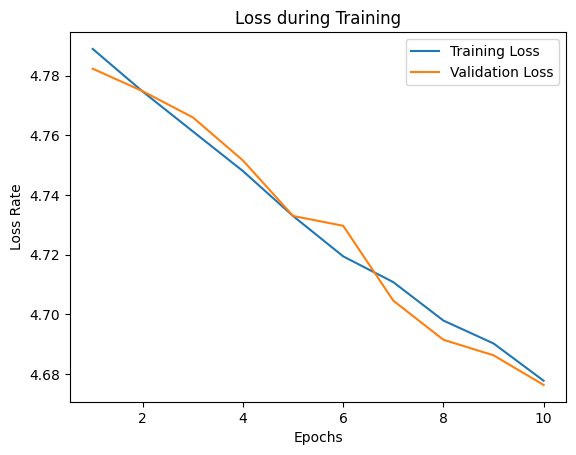

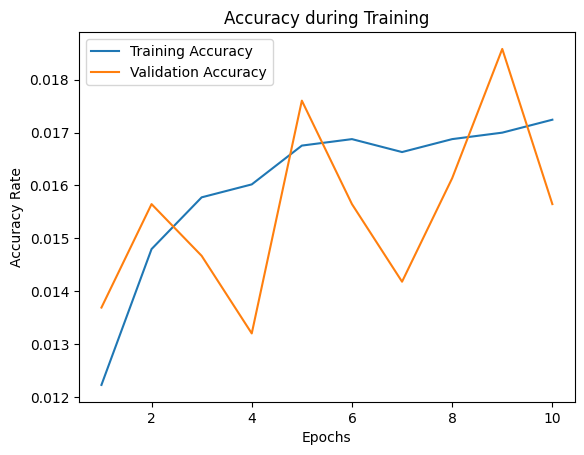

In [39]:
# Plot accuracy and loss
# Number of values in each list should align to how many epochs were needed to train
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print(len(loss), type(loss))
# Initialize x-axis for plots - first plot the loss, then the accuracy
epochs = list(range(1, len(loss) + 1))

# Loss
plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title("Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Loss Rate")
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title("Accuracy during Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Rate")
plt.legend()
plt.show()

<a id='Different'></a>
## <h1>Trying a Different Model</h1>

Try another model to see if we can get better predictions.<br>
<br>

First, perform some image augmentation using ImageDataGenerator on the train data.<br>
Also, set up a data generator for validation data.<br>

We will use ResNet50V2 as the architecture to try and get better predictions.

In [40]:
train_data_gen = ImageDataGenerator(
    rescale=1./224., rotation_range=45,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True
)

valid_data_gen = ImageDataGenerator(rescale=1./ 224.)

In [41]:
train_gen = train_data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE)
valid_gen = valid_data_gen.flow(x_valid, y_valid, batch_size=BATCH_SIZE)

In [42]:
# Create the ResNet50V2 model - exclude top network layer which would be fully connected
model = ResNet50V2(input_shape=[IMG_SIZE, IMG_SIZE, 3], weights='imagenet', include_top=False)

for layer in model.layers:
    layer.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [43]:
# model.layers

In [44]:
# Get summary of base model
model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [45]:
last_layer = model.get_layer('post_relu')
last_layer_output = last_layer.output
last_layer_output.name

'keras_tensor_219'

In [46]:
last_layer_output.shape

(None, 7, 7, 2048)

In [47]:
# Set up layers for the model, then initialize using base to compile the model

# Get layers to be one single dimension
x = layers.Flatten()(last_layer_output)

# Add a layer with 256 units and ReLU, which would make this layer fully connected
x = layers.Dense(256, activation='relu')(x)

# Normalize the batch
x = layers.BatchNormalization()(x)

# Add another layer with 512 units and ReLU, which would make this layer fully connected
x = layers.Dense(512, activation='relu')(x)
# Set dropout rate to 0.6
x = layers.Dropout(0.6)(x)

# Add another layer with 1024 units and ReLU, which would make this layer fully connected
x = layers.Dense(1024, activation='relu')(x)
# Set dropout rate to 0.6
x = layers.Dropout(0.6)(x)


# Make a sigmoid layer with sigmoid
x = layers.Dense(1, activation='sigmoid')(x)

# Set dropout rate to 0.6
x = layers.Dropout(0.6)(x)

# Normalize the batch again
x = layers.BatchNormalization()(x)

# Initialize the output variable using dense softmax layer
output = layers.Dense(120, activation='softmax')(x)

model = models.Model(model.input, output)
# model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), 
#               loss='binary_crossentropy', metrics=['acc'])



In [48]:
from keras.optimizers import RMSprop

optimizer = RMSprop(learning_rate=LEARNING_RATE, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [49]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [50]:
# history = model.fit(x_train, y_train, epochs=10, 
#                     validation_data=(x_valid, y_valid),
#                    verbose=1, callbacks=[reduce_lr, early_stop])

In [51]:
# # Compile the model
# base_model.compile(
# 	optimizer='adam',
# 	loss='categorical_crossentropy',
# 	metrics=[tf.keras.metrics.AUC()]
# )


In [52]:
# # Train the model
# history = base_model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
#                     epochs=10, verbose=1
#                    )



In [53]:
# history.history

In [54]:
# # Get valid_data_gen to run on validation data
# valid_data_gen = ImageDataGenerator(rescale=1./ 255.)


In [55]:
# valid_data_gen = ImageDataGenerator(rescale=1./ 255.)
# valid_gen = valid_data_gen.flow_from_directory('/kaggle/input/dog-breed-identification', target_size=(224, 224), 
#                                                class_mode='categorical', classes=['test'])

In [56]:
# y_pred= model.predict(valid_gen)